### Includes
Here are the import all the libraries

In [1]:
%matplotlib inline
import sys
import time
import collections
import operator
import math
import pickle
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.style.use('seaborn-whitegrid')

## Experiments Overview
#### Loading Results

In [2]:
# -- loading experiments results
def load(LR, DR, CA, L):
    # file name
    name = 'LR,DR,CA' if (LR and DR and CA) else \
           'LR' if (LR) else \
           'DR' if (DR) else 'CA'
    # load
    df = pickle.load(open('tmp/experiments/%s-L%d.df.bin' % (name, L), 'rb'))
    # clean data
    df = df.drop(['pre.famous', 'pre.famous-std',
                  'pre.normal', 'pre.normal-std',
                  'rec.famous', 'rec.famous-std',
                  'rec.normal', 'rec.normal-std'], axis=1)
    return df


# Example loading result
print('Best results - without Hyperparameter Tuning')
load(1, 1, 1, 9).sort_values(by='acc', ascending=False).head(5)

Best results - without Hyperparameter Tuning


,acc,acc-std,f1,f1-std,pre,pre-std,rec,rec-std
LogisticRegression,0.808333,0.108733,0.745000,0.142695,0.808333,0.108733,0.733333,0.157894
RidgeClassifierCV,0.775000,0.105492,0.685000,0.144263,0.733333,0.131498,0.675000,0.155289
LinearSVC,0.750000,0.113346,0.688333,0.139943,0.750000,0.111803,0.683333,0.154560
RidgeClassifier,0.741667,0.124234,0.670000,0.153152,0.733333,0.131498,0.658333,0.166093
GaussianProcessClassifier,0.708333,0.138506,0.655000,0.161204,0.708333,0.147019,0.650000,0.170579


#### Classifiers

In [3]:
# -- classifiers used
classifiers = ['AdaBoostClassifier', 'BaggingClassifier', 'BernoulliNB',
               'CalibratedClassifierCV', 'ComplementNB', 'DecisionTreeClassifier',
               'ExtraTreeClassifier', 'ExtraTreesClassifier', 'GaussianNB',
               'GaussianProcessClassifier', 'GradientBoostingClassifier',
               'KNeighborsClassifier', 'LinearDiscriminantAnalysis', 'LinearSVC',
               'LogisticRegression', 'LogisticRegressionCV', 'MLPClassifier',
               'MultinomialNB', 'NearestCentroid', 'NuSVC',
               'PassiveAggressiveClassifier', 'Perceptron',
               'QuadraticDiscriminantAnalysis', 'RandomForestClassifier',
               'RidgeClassifier', 'RidgeClassifierCV', 'SGDClassifier', 'SVC']

print('classifiers:', len(classifiers))

classifiers: 28


#### Get the experiments over $L$

In [4]:
def list_evaluation(LR, DR, CA, evaluation='acc', L_MAX=10):
    ev = {classifier: [] for classifier in classifiers}
    for i in range(1, L_MAX+1):
        df = load(LR=LR, DR=DR, CA=CA, L=i)
        for classifier in classifiers:
            ev[classifier].append(df.loc[classifier][evaluation])
    return ev

#### Max Accuracy in $L = [1, 10]$

In [5]:
TOP = 6
def max_evaluation(LR, DR, CA, evaluation):
    resp = list_evaluation(LR=LR, DR=DR, CA=CA, evaluation=evaluation)
    ev = []
    for classifier in classifiers:
        ev.append((max(resp[classifier]), classifier))
    ranked = sorted(ev, key=lambda tup: tup[0], reverse=True)
    return resp, [tup[1] for tup in ranked][0:TOP], ranked

#### Plot Function

In [6]:
fontsize = 16
width = 9
height = 3.5

markers = ['X','v','o','s','>','X','<','p','^','d']
lines = ['-']*3 + [':']*(TOP-3)
sizes = [8]*3 + [5]*(TOP-3)

# Linear Plot
def plot_evaluation(evaluation, classifiers, x='$L$', y='evaluation', name=''):
    fig, axis = plt.subplots()
    X = range(1, 11)
    plt.ylabel(r'%s' % (y.capitalize()), fontsize=fontsize)
    plt.xlabel(r'%s' % (x), fontsize=fontsize)
    for classifier in classifiers:
        idx = classifiers.index(classifier)
        plt.plot(X, evaluation[classifier], label=classifier, 
                 marker=markers[idx], linestyle=lines[idx], markersize=sizes[idx])
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=fontsize-3, ncol=1)
    plt.tick_params(axis='both', which='major', labelsize=fontsize-2)
    # -- ticks
    plt.ylim(0.39, .81)
    plt.xlim(1, 10)
    plt.yticks([0.35, 0.45, 0.55, 0.65, 0.75, 0.85])
    plt.xticks(range(1, 11))
    # -- size
    fig.set_size_inches(width, height)
    plt.tight_layout()
    #plt.savefig('linear-%s-%s.pdf' % (name, y), dpi=300)
    
    plt.show()

# Heatmap Plot
def heatmap_evaluation(evaluation, classifiers, x='$L$', y='evaluation', name=''):
    fig, axis = plt.subplots()
    X = range(1, 11)
    Y = len(classifiers)
    plt.ylabel(r'%s' % ('Classifiers'), fontsize=fontsize)
    plt.xlabel(r'%s' % (x), fontsize=fontsize)
    arr = np.random.random((Y, 10))
    for i in range(Y):
        classifier = classifiers[i]
        for j in X:
            arr[i][j-1] = evaluation[classifier][j-1]
    
    #cmap = BuPu | OrRd | hot | binary
    heatmap = plt.imshow(arr, cmap='OrRd', interpolation='nearest', vmin=0.35, vmax=0.85)
    # -- ticks
    axis.invert_yaxis()
    plt.tick_params(axis='both', which='major', labelsize=fontsize-2)
    plt.xticks(range(0, 10), range(1, 11))
    plt.yticks(range(Y), classifiers) #axis.yaxis.set_tick_params(rotation=45)
    # -- bar
    divider = make_axes_locatable(axis)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(heatmap, cax=cax)
    # -- size
    fig.set_size_inches(width, height)
    plt.tight_layout()
    #plt.savefig('heatmap-%s-%s.pdf' % (name, y), dpi=300)
    
    plt.show()

## Experiment 1

LR- accuracy


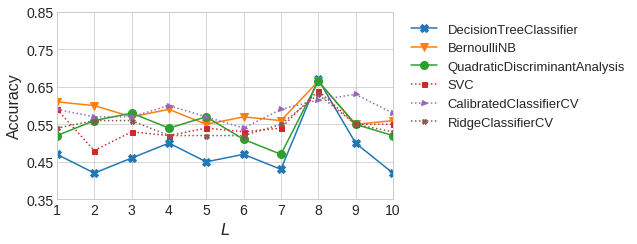

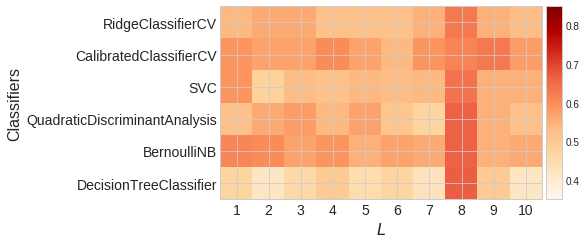

LR- f1-score


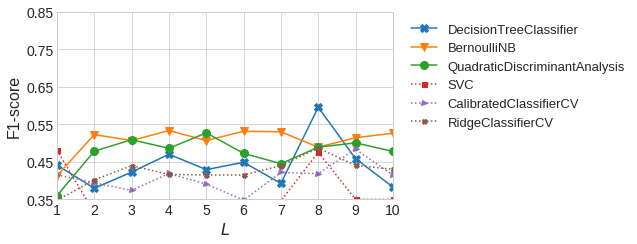

,acc,acc-std,f1,f1-std,pre,pre-std,rec,rec-std
DecisionTreeClassifier,0.670,0.079215,0.595595,0.100310,0.621667,0.109801,0.645833,0.100886
BernoulliNB,0.665,0.106683,0.489048,0.131271,0.432500,0.145672,0.600000,0.100000
QuadraticDiscriminantAnalysis,0.665,0.106683,0.489048,0.131271,0.432500,0.145672,0.600000,0.100000
SVC,0.640,0.121861,0.475714,0.136639,0.424167,0.148785,0.575000,0.112500
RidgeClassifierCV,0.630,0.115217,0.486429,0.125954,0.497500,0.149223,0.533333,0.110161
CalibratedClassifierCV,0.615,0.108426,0.418571,0.105060,0.374167,0.115612,0.512500,0.090355


In [7]:
# -- acc
print('LR-', 'accuracy')
ev, clfs, _ = max_evaluation(LR=True, DR=False, CA=False, evaluation='acc')
plot_evaluation(ev, clfs, y='accuracy', name='lr')
heatmap_evaluation(ev, clfs, y='accuracy', name='lr')

# -- f1-score
print('LR-', 'f1-score')
ev, _, _ = max_evaluation(LR=True, DR=False, CA=False, evaluation='f1')
plot_evaluation(ev, clfs, y='f1-score', name='lr')

# -- print
load(True, 0, 0, 8).loc[clfs].sort_values(by='acc', ascending=False)

DR- accuracy


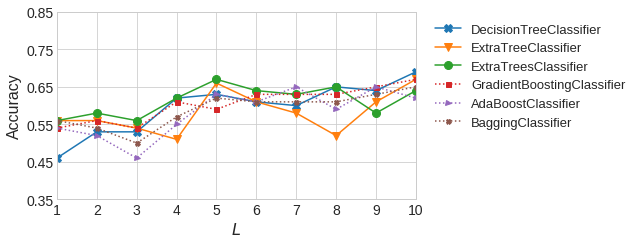

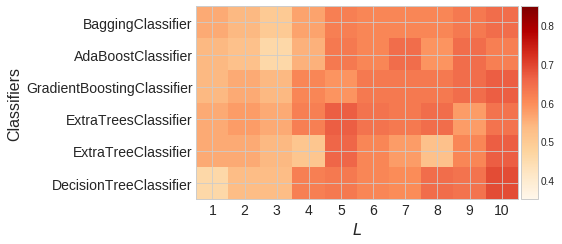

DR- f1-score


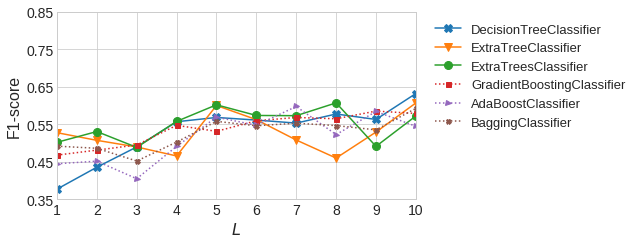

,acc,acc-std,f1,f1-std,pre,pre-std,rec,rec-std
DecisionTreeClassifier,0.69,0.065000,0.632252,0.073972,0.680655,0.089898,0.658333,0.070483
ExtraTreeClassifier,0.67,0.067268,0.607078,0.087670,0.616409,0.101319,0.653690,0.075385
GradientBoostingClassifier,0.67,0.055000,0.579086,0.077863,0.593016,0.102502,0.613750,0.058778
BaggingClassifier,0.65,0.075000,0.592590,0.093115,0.621250,0.106019,0.630833,0.082291
ExtraTreesClassifier,0.64,0.064031,0.572326,0.072924,0.604762,0.087025,0.613155,0.070521
AdaBoostClassifier,0.62,0.076811,0.544733,0.095835,0.532123,0.103813,0.603690,0.081405


In [8]:
# -- acc
print('DR-', 'accuracy')
ev, clfs, _ = max_evaluation(LR=False, DR=True, CA=False, evaluation='acc')
plot_evaluation(ev, clfs, y='accuracy', name='dr')
heatmap_evaluation(ev, clfs, y='accuracy', name='dr')

# -- f1-score
print('DR-', 'f1-score')
ev, _, _ = max_evaluation(LR=False, DR=True, CA=False, evaluation='f1')
plot_evaluation(ev, clfs, y='f1-score', name='dr')

# -- print
load(0, True, 0, 10).loc[clfs].sort_values(by='acc', ascending=False)

CA- accuracy


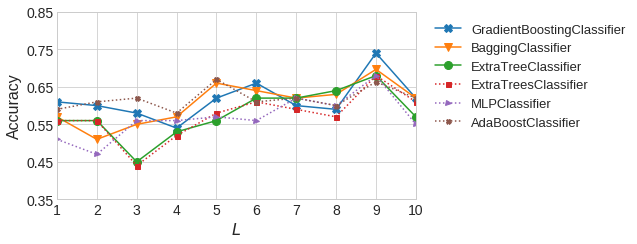

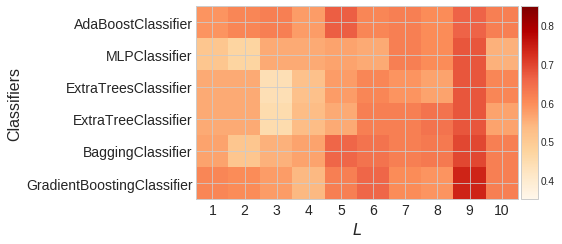

CA- f1-score


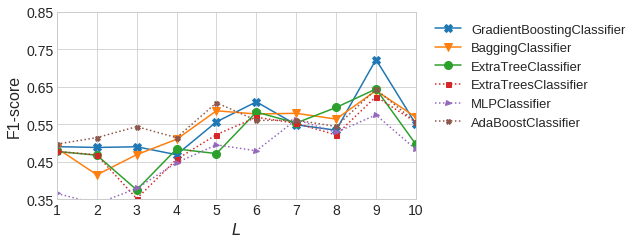

,acc,acc-std,f1,f1-std,pre,pre-std,rec,rec-std
GradientBoostingClassifier,0.740000,0.069442,0.722976,0.072056,0.745833,0.068750,0.766667,0.076376
BaggingClassifier,0.696667,0.090814,0.640040,0.096459,0.648333,0.104795,0.675000,0.106148
ExtraTreeClassifier,0.680000,0.071570,0.644286,0.079624,0.650833,0.086652,0.687500,0.091879
ExtraTreesClassifier,0.680000,0.055877,0.624087,0.058708,0.673333,0.070558,0.679167,0.063908
MLPClassifier,0.680000,0.055877,0.575159,0.088578,0.579167,0.103065,0.625000,0.090810
AdaBoostClassifier,0.663333,0.049694,0.643452,0.048163,0.670833,0.047917,0.695833,0.062535


In [9]:
# -- acc
print('CA-', 'accuracy')
ev, clfs, _ = max_evaluation(LR=False, DR=False, CA=True, evaluation='acc')
plot_evaluation(ev, clfs, y='accuracy', name='ca')
heatmap_evaluation(ev, clfs, y='accuracy', name='ca')

# -- f1-score
print('CA-', 'f1-score')
ev, _, _ = max_evaluation(LR=False, DR=False, CA=True, evaluation='f1')
plot_evaluation(ev, clfs, y='f1-score', name='ca')

# -- print
load(0, 0, True, 9).loc[clfs].sort_values(by='acc', ascending=False)

## Experiment 2

ALL- accuracy


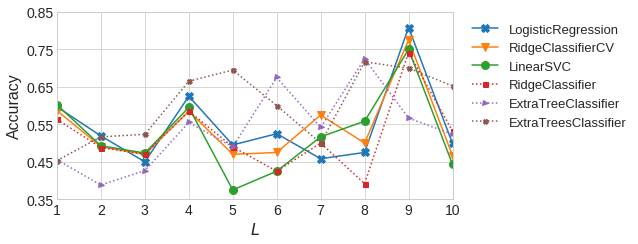

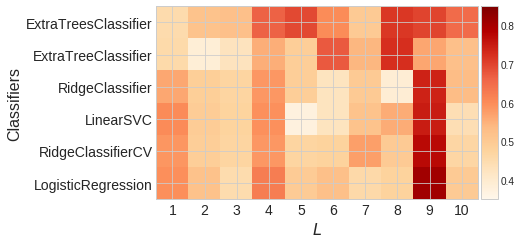

ALL- f1-score


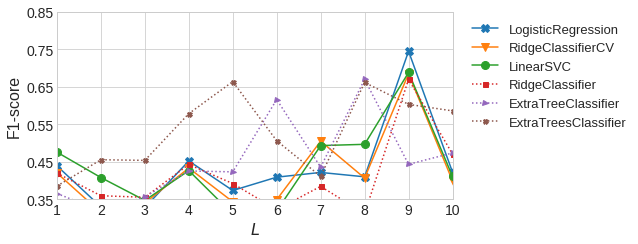

,acc,acc-std,f1,f1-std,pre,pre-std,rec,rec-std
LogisticRegression,0.808333,0.108733,0.745000,0.142695,0.808333,0.108733,0.733333,0.157894
RidgeClassifierCV,0.775000,0.105492,0.685000,0.144263,0.733333,0.131498,0.675000,0.155289
LinearSVC,0.750000,0.113346,0.688333,0.139943,0.750000,0.111803,0.683333,0.154560
RidgeClassifier,0.741667,0.124234,0.670000,0.153152,0.733333,0.131498,0.658333,0.166093
ExtraTreesClassifier,0.700000,0.116667,0.603333,0.146097,0.666667,0.127748,0.616667,0.157233
ExtraTreeClassifier,0.566667,0.130171,0.443333,0.131191,0.508333,0.133658,0.441667,0.145595


In [10]:
# -- acc
print('ALL-', 'accuracy')
ev, clfs, _ = max_evaluation(LR=True, DR=True, CA=True, evaluation='acc')
plot_evaluation(ev, clfs, y='accuracy', name='all')
heatmap_evaluation(ev, clfs, y='accuracy', name='all')

# -- f1-score
print('ALL-', 'f1-score')
ev, _, _ = max_evaluation(LR=True, DR=True, CA=True, evaluation='f1')
plot_evaluation(ev, clfs, y='f1-score', name='all')

# -- print
load(True, True, True, 9).loc[clfs].sort_values(by='acc', ascending=False)